

* This dataset consists of 1 Million+ transaction by over 800K customers for a bank in India.
* The data contains information such as - customer age (DOB), location, gender, account balance at the time of the transaction , transactiondetails,transaction amount, etc.  

# Objective of this project:

1. Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
2. Perform Location-wise analysis to identify regional trends in India
3. Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
4. Customer Recency, Frequency, Monetary analysis
5. Network analysis or Graph analysis of customer data.

**Table of contents of this notebook:**

1. Importing Necessary Libraries

2. Data Collection

3. Data Cleaning

4. Exploratory Data Analysis

5. Feature Engineering

6. Modelling

7. Classification Problem

8. Modelling for Classification

### 1. Importing Necessary Libraries

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a9368eeb37446a6bb2e6f8b43748e9c5a751f8a2c883b19f7e7eba05774693dd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
pip install kneed

In [3]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pyspark.sql import SparkSession

#import regex as re
import plotly.express as px
from datetime import timedelta
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, when, max as spark_max, count, isnan, monotonically_increasing_id, unix_timestamp, percentile_approx
from pyspark.ml.feature import StandardScaler, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType




In [4]:
spark = SparkSession.builder.appName('segmentation').config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

### 2. Data Collection

In [35]:
df=spark.read.csv("bank_transaction.csv",header = True,inferSchema=True)
df.show(20)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053|  10/1/1994|         F|  JAMSHEDPUR|          17819.05|       2/8/2016|         143207|                   25.0|
|           T2|  C2142763|   4/4/1957|         M|     JHAJJAR|           2270.69|       2/8/2016|         141858|                27999.0|
|           T3|  C4417068|   26/11/96|         F|      MUMBAI|          17874.44|       2/8/2016|         142712|                  459.0|
|           T4|  C5342380|    14/9/73|         F|      MUMBAI|         866503.21|       2/8/2016|         142714|                 2060.0|
|           T5|  C9031234|    24/3

### 3. Data Cleaning

In [6]:
## Show detailes data set
def check(df):
    l = []
    columns = df.columns
    for col in columns:
        dtypes = df.select(col).dtypes[0][1]  # Get data type
        nunique = df.select(col).distinct().count()  # Get number of unique values
        sum_null = df.filter(F.col(col).isNull()).count()  # Get number of null values
        l.append([col, dtypes, nunique, sum_null])

    # Convert list to pandas DataFrame for better readability
    df_check = pd.DataFrame(l, columns=['column', 'dtypes', 'nunique', 'sum_null'])
    return df_check

# Example usage
check_result = check(df)
print(check_result)


                    column  dtypes  nunique  sum_null
0            TransactionID  string  1048567         0
1               CustomerID  string   884265         0
2              CustomerDOB  string    17255         0
3               CustGender  string        4      1100
4             CustLocation  string     9356       151
5       CustAccountBalance  double   161329      2369
6          TransactionDate  string       55         0
7          TransactionTime     int    81918         0
8  TransactionAmount (INR)  double    93024         0


In [36]:
# converting CustomerDOB and TransactionDate to date format

from pyspark.sql.functions import regexp_extract, length, when, concat, lit, split, col, to_date

def process_and_convert_date_column(df, column_name):
    df_processed = df.withColumn(f"{column_name}_DateParts", split(col(column_name), "/")  # Split the date string into parts
    ).withColumn(f"{column_name}_YearPart",
        when(
            (length(col(f"{column_name}_DateParts")[2]) == 2) & (col(f"{column_name}_DateParts")[2].cast("int") > 16),
            concat(lit("19"), col(f"{column_name}_DateParts")[2])  # If 2-digit year > 16, prepend '19'
        ).when(
              (length(col(f"{column_name}_DateParts")[2]) == 2) & (col(f"{column_name}_DateParts")[2].cast("int") <= 16),
              concat(lit("20"), col(f"{column_name}_DateParts")[2])  # If 2-digit year <= 16, prepend '20'
        ).otherwise(col(f"{column_name}_DateParts")[2])  # If 4-digit year, keep as is
        ).withColumn(f"{column_name}_Processed_and_formatted", to_date(
        concat(
            col(f"{column_name}_DateParts")[0], lit("/"),  # Day
            col(f"{column_name}_DateParts")[1], lit("/"),  # Month
            col(f"{column_name}_YearPart")  # Four-digit year
        ),"d/M/yyyy")  # Specify the input date format
        )
    return df_processed      # Return the processed DataFrame

# Process and convert both CustomerDOB and TransactionDate columns
df = process_and_convert_date_column(df, "CustomerDOB")
df = process_and_convert_date_column(df, "TransactionDate")

# Show the updated columns
df.show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+---------------------+--------------------+-----------------------------------+-------------------------+------------------------+---------------------------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerDOB_DateParts|CustomerDOB_YearPart|CustomerDOB_Processed_and_formatted|TransactionDate_DateParts|TransactionDate_YearPart|TransactionDate_Processed_and_formatted|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+---------------------+--------------------+-----------------------------------+-------------------------+------------------------+---------------------------------------+
|           T1|  C5841053|  10/1/1994|         F|  JAMSHEDPUR|          1781

In [37]:
df = df.drop("CustomerDOB", "TransactionDate", "CustomerDOB_DateParts", "CustomerDOB_YearPart", "TransactionDate_DateParts", "TransactionDate_YearPart")

In [38]:
df = df.withColumnRenamed("CustomerDOB_Processed_and_formatted", "CustomerDOB").withColumnRenamed("TransactionDate_Processed_and_formatted", "TransactionDate")

In [39]:
df.show(5)

+-------------+----------+----------+------------+------------------+---------------+-----------------------+-----------+---------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|CustomerDOB|TransactionDate|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+-----------+---------------+
|           T1|  C5841053|         F|  JAMSHEDPUR|          17819.05|         143207|                   25.0| 1994-01-10|     2016-08-02|
|           T2|  C2142763|         M|     JHAJJAR|           2270.69|         141858|                27999.0| 1957-04-04|     2016-08-02|
|           T3|  C4417068|         F|      MUMBAI|          17874.44|         142712|                  459.0| 1996-11-26|     2016-08-02|
|           T4|  C5342380|         F|      MUMBAI|         866503.21|         142714|                 2060.0| 1973-09-14|     2016-08-02|
|           T5|  C9031234|        

In [ ]:
df.toPandas().shape

(1048567, 9)

wow, the shape of the data is very big 😵😵

In [11]:
df.describe().show()

+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|summary|TransactionID|CustomerID|CustGender|        CustLocation|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|  count|      1048567|   1048567|   1047467|             1048416|           1046198|           1048567|                1048567|
|   mean|         NULL|      NULL|      NULL|            400012.0|115403.54005621927|157087.52939297154|     1574.3350034570226|
| stddev|         NULL|      NULL|      NULL|                 0.0|  846485.380600656|  51261.8540223295|      6574.742978453976|
|    min|           T1|  C1010011|         F|(154) BHASKOLA FA...|               0.0|                 0|                    0.0|
|    max|      T999999|  C9099956|         T|           ZUNHEBOTO|     1.150354951E8|            

In [42]:
from pyspark.sql.functions import month, to_date, col

# Get distinct months from TransactionDate
distinct_months_TransactionDate = df.withColumn("Month", month("TransactionDate")).select("Month").distinct().orderBy("Month").show()

# Get distinct years from TransactionDate
distinct_years_TransactionDate = df.withColumn("year", year("TransactionDate")).select("year").distinct().orderBy("year").show()

+-----+
|Month|
+-----+
|    8|
|    9|
|   10|
+-----+

+----+
|year|
+----+
|2016|
+----+



In [43]:
# Get distinct months from CustomerDOB
distinct_months_CustomerDOB = df.withColumn("Month", month("CustomerDOB")).select("Month").distinct().orderBy("Month").show()

# Get distinct years from CustomerDOB
distinct_years_CustomerDOB = df.withColumn("year", year("CustomerDOB")).select("year").distinct().orderBy("year").show()

+-----+
|Month|
+-----+
| NULL|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
|    9|
|   10|
|   11|
|   12|
+-----+

+----+
|year|
+----+
|NULL|
|1800|
|1919|
|1921|
|1922|
|1926|
|1927|
|1928|
|1929|
|1930|
|1931|
|1932|
|1933|
|1934|
|1935|
|1936|
|1937|
|1938|
|1939|
|1940|
+----+
only showing top 20 rows



In [46]:
df = df.filter(F.year(F.col("CustomerDOB")) != 1800)

In [47]:
# Get distinct years from CustomerDOB
distinct_years_CustomerDOB = df.withColumn("year", year("CustomerDOB")).select("year").distinct().orderBy("year").show()

+----+
|year|
+----+
|1919|
|1921|
|1922|
|1926|
|1927|
|1928|
|1929|
|1930|
|1931|
|1932|
|1933|
|1934|
|1935|
|1936|
|1937|
|1938|
|1939|
|1940|
|1941|
|1942|
+----+
only showing top 20 rows



<p> calculate customer age :</p>
<p> CustomerDOB is the birth date of the customer , TransactionDate : is the date of transaction that customer is done
</p>

In [48]:
df = df.withColumn('CustomerAge', year(col('TransactionDate')) - year(col('CustomerDOB')))

I'm going to get rid of TransactionTime since I'm uncertain about what it refers to, specifically which days, hours, or minutes are encompassed in it. 🤷‍

In [49]:
df = df.drop('TransactionTime')

In [50]:
gender_counts = df.groupBy("CustGender").agg(count("CustGender").alias("count")).show()

+----------+------+
|CustGender| count|
+----------+------+
|         F|273548|
|      NULL|     0|
|         M|714119|
+----------+------+



In [51]:
# dropping gender == 'T'
df = df.filter(df.CustGender != 'T')

In [15]:
gender_counts = df.groupBy("CustGender").agg(count("CustGender").alias("count")).show()

+----------+------+
|CustGender| count|
+----------+------+
|         F|281936|
|         M|765530|
+----------+------+



Now the data is cleaned and I will perform RFM on it.

In [52]:
# delete missing data
df = df.dropna()

In [53]:
#drop duplicates
df = df.dropDuplicates()

In [54]:
## Show detailes data set
def check(df):
    l = []
    columns = df.columns
    for col in columns:
        dtypes = df.select(col).dtypes[0][1]  # Get data type
        nunique = df.select(col).distinct().count()  # Get number of unique values
        sum_null = df.filter(F.col(col).isNull()).count()  # Get number of null values
        l.append([col, dtypes, nunique, sum_null])

    # Convert list to pandas DataFrame for better readability
    df_check = pd.DataFrame(l, columns=['column', 'dtypes', 'nunique', 'sum_null'])
    return df_check

# Example usage
check_result = check(df)
print(check_result)

                    column  dtypes  nunique  sum_null
0            TransactionID  string   985322         0
1               CustomerID  string   839081         0
2               CustGender  string        2         0
3             CustLocation  string     8164         0
4       CustAccountBalance  double   152833         0
5  TransactionAmount (INR)  double    86783         0
6              CustomerDOB    date    17232         0
7          TransactionDate    date       55         0
8              CustomerAge     int      103         0


In [55]:
df.toPandas().shape

(985322, 9)

<img src="https://miro.medium.com/max/638/0*JddVeZpHXdElEec_" alt="RFM" >

<p>Recency: number of days since the last purchase or order so I will create a new column of TransactionDate to subtract the last transaction from the first transaction</p>

In [56]:
# the max date in the dataset
snapshot_date = df.agg(spark_max("TransactionDate")).collect()[0][0] + pd.Timedelta(days=1)
snapshot_date

datetime.date(2016, 10, 22)

In [57]:
df = df.withColumn('TransactionDate1', col('TransactionDate'))
df.show(5)

+-------------+----------+----------+--------------+------------------+-----------------------+-----------+---------------+-----------+----------------+
|TransactionID|CustomerID|CustGender|  CustLocation|CustAccountBalance|TransactionAmount (INR)|CustomerDOB|TransactionDate|CustomerAge|TransactionDate1|
+-------------+----------+----------+--------------+------------------+-----------------------+-----------+---------------+-----------+----------------+
|         T257|  C5212180|         F|        MUMBAI|         168034.54|                   10.0| 1986-03-18|     2016-10-21|         30|      2016-10-21|
|         T270|  C2526046|         F|       KOLKATA|          31369.53|                 1735.0| 1988-01-07|     2016-10-21|         28|      2016-10-21|
|         T342|  C5484469|         M|       JAUNPUR|           2643.71|                  200.0| 1992-04-13|     2016-10-21|         24|      2016-10-21|
|        T1835|  C3515792|         F|STUD FARM PUNE|          66579.81|           

In [58]:
# Define a UDF to calculate days difference
def days_diff(max_date, snapshot_date):
    return (snapshot_date - max_date).days

days_diff_udf = F.udf(lambda date: days_diff(date, snapshot_date), IntegerType())

# Adding a median function workaround
def approx_median(col):
    return F.expr(f'percentile_approx({col}, 0.5)')

# Grouping and Aggregating
RFM_df = df.groupBy("CustomerID").agg(
    F.count("TransactionID").alias("Frequency"),  # TransactionID = Frequency
    F.first("CustGender").alias("CustGender"),
    F.first("CustLocation").alias("CustLocation"),
    F.mean("CustAccountBalance").alias("CustAccountBalance"),
    F.sum("TransactionAmount (INR)").alias("Monetary"),  # TransactionAmount (INR) = Monetary
    approx_median("CustomerAge").alias("CustomerAge"),
    days_diff_udf(F.max("TransactionDate")).alias("Recency"),
    approx_median("TransactionDate1").alias("TransactionDate")
)


In [59]:
RFM_df.show(5)

+----------+---------+----------+------------+------------------+--------+-----------+-------+---------------+
|CustomerID|Frequency|CustGender|CustLocation|CustAccountBalance|Monetary|CustomerAge|Recency|TransactionDate|
+----------+---------+----------+------------+------------------+--------+-----------+-------+---------------+
|  C1010011|        2|         M|   NEW DELHI|         76340.635|  5106.0|         24|     26|     2016-08-09|
|  C1010012|        1|         M|      MUMBAI|          24204.49|  1499.0|         22|     69|     2016-08-14|
|  C1010024|        1|         M|     KOLKATA|          87058.65|  5000.0|         51|     65|     2016-08-18|
|  C1010028|        1|         F|       DELHI|         296828.37|   557.0|         28|     54|     2016-08-29|
|  C1010035|        2|         M|      MUMBAI|        192648.755|   750.0|         24|     56|     2016-08-01|
+----------+---------+----------+------------+------------------+--------+-----------+-------+---------------+
o

In [24]:
RFM_df.describe().show()

+-------+----------+------------------+----------+--------------------+------------------+------------------+------------------+------------------+
|summary|CustomerID|         Frequency|CustGender|        CustLocation|CustAccountBalance|          Monetary|       CustomerAge|           Recency|
+-------+----------+------------------+----------+--------------------+------------------+------------------+------------------+------------------+
|  count|    879357|            879357|    879357|              879357|            879357|            879357|            879357|            879357|
|   mean|      NULL|1.1845166411366488|      NULL|            400012.0|114715.09338760829|1855.0316898824235| 38.95905644692656| 56.30826387917535|
| stddev|      NULL|0.4489544325035586|      NULL|                NULL| 801084.2405006572| 7188.245222904097|39.730717437535134|15.227481360067465|
|    min|  C1010011|                 1|         F|(154) BHASKOLA FA...|               0.0|               0.0|   

In [60]:
RFM_df.toPandas().shape

(839081, 9)

In [61]:
RFM_df = RFM_df.drop("CustomerID")

<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">4. Exploratory Data Analysis</h2><a id = "4"></a>

In [62]:
from pyspark.sql.types import NumericType

# Identify numeric columns
numeric_columns = [c for c, t in RFM_df.dtypes if isinstance(RFM_df.schema[c].dataType, NumericType)]

# Select numeric columns
num_df = RFM_df.select(numeric_columns)
num_df.show(5)



+---------+------------------+--------+-----------+-------+
|Frequency|CustAccountBalance|Monetary|CustomerAge|Recency|
+---------+------------------+--------+-----------+-------+
|        2|         76340.635|  5106.0|         24|     26|
|        1|          24204.49|  1499.0|         22|     69|
|        1|          87058.65|  5000.0|         51|     65|
|        1|         296828.37|   557.0|         28|     54|
|        2|        192648.755|   750.0|         24|     56|
+---------+------------------+--------+-----------+-------+
only showing top 5 rows



<Axes: >

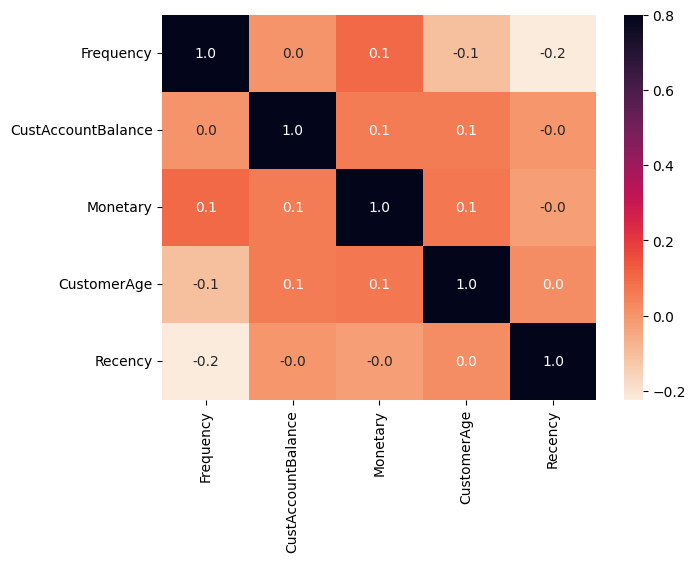

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(num_df.toPandas().corr(), vmin=None, vmax=0.8, cmap='rocket_r', annot=True, fmt='.1f', linecolor='white', cbar=True)


<ipython-input-63-6be81719c23c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_df_pd[num_df_pd.columns[i]], kde_kws={'color': 'b', 'bw': 0.1, 'lw': 3, 'label': 'KDE'}, hist_kws={'color': 'g'})
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-63-6be81719c23c>:8: UserWarning: 

`distplot` is a deprecated function and 

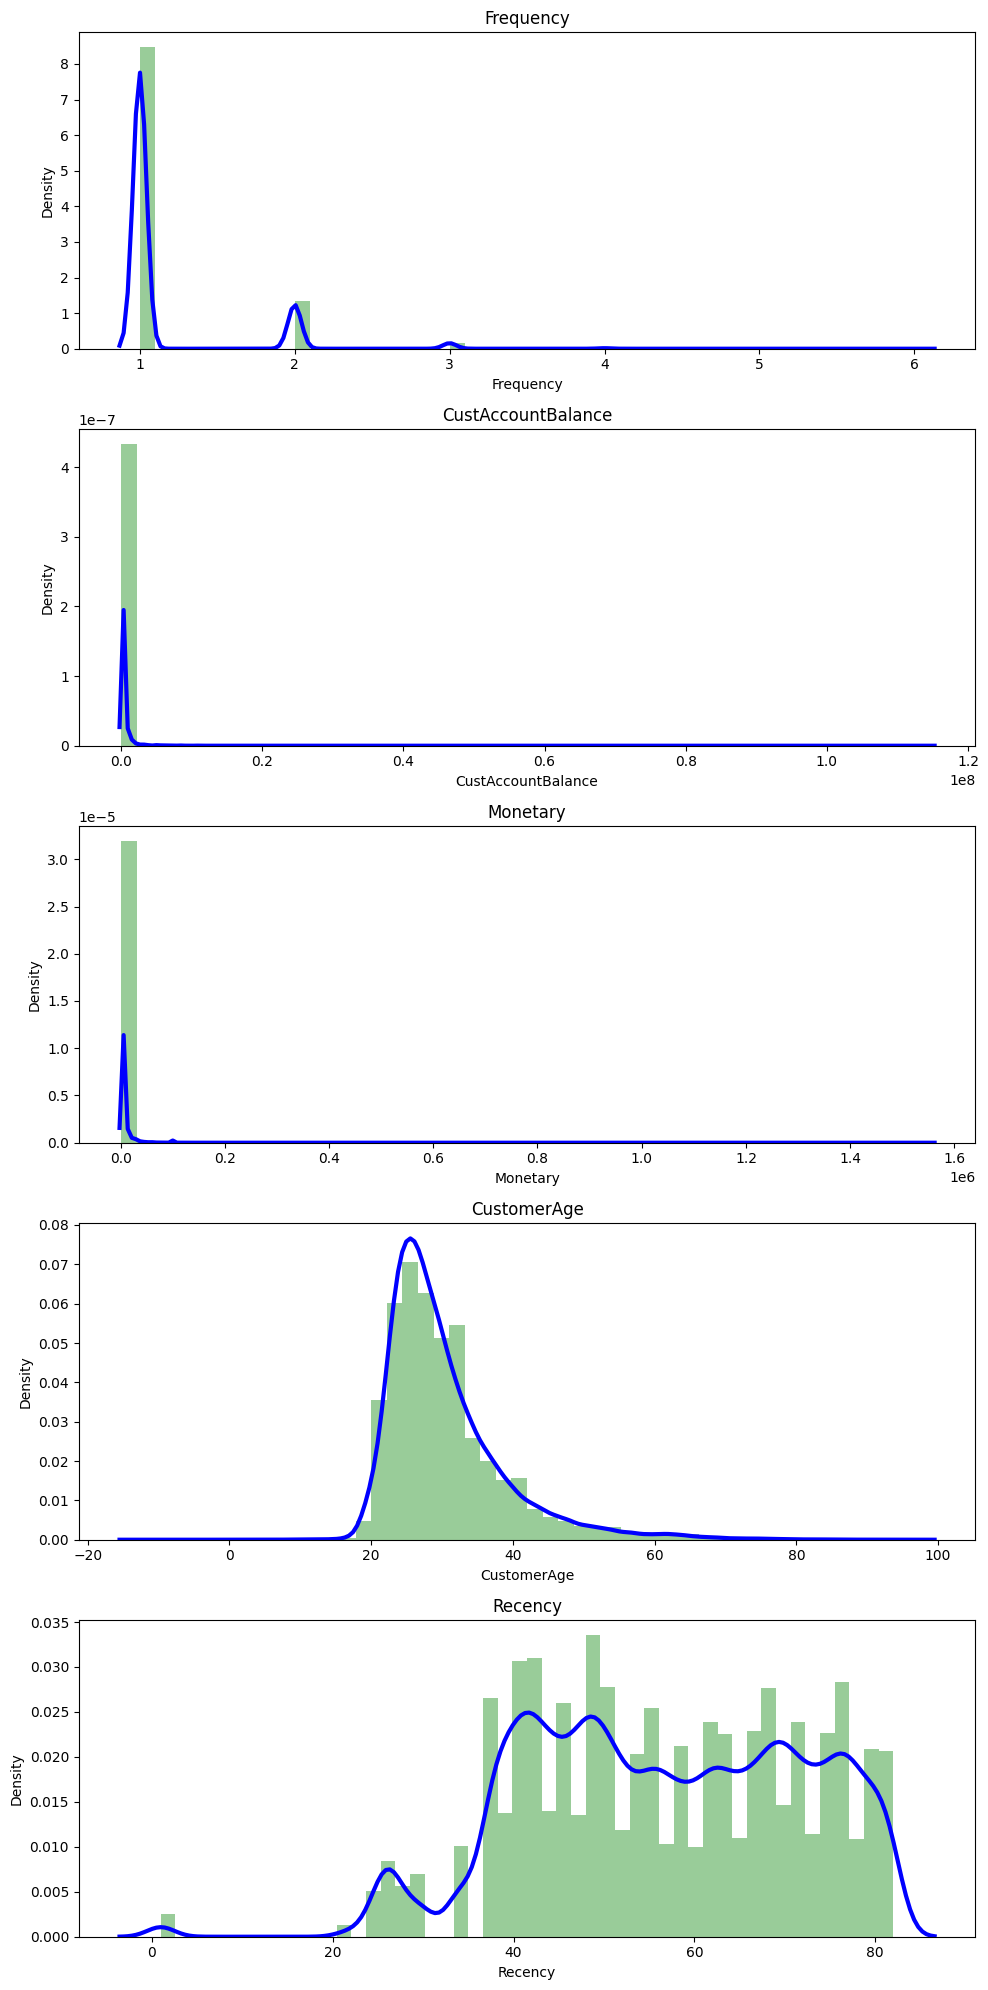

In [63]:
# Convert PySpark DataFrame to Pandas DataFrame
num_df_pd = num_df.toPandas()

# Plotting
plt.figure(figsize=(10, 20))
for i in range(len(num_df_pd.columns)):
    plt.subplot(len(num_df_pd.columns), 1, i + 1)
    sns.distplot(num_df_pd[num_df_pd.columns[i]], kde_kws={'color': 'b', 'bw': 0.1, 'lw': 3, 'label': 'KDE'}, hist_kws={'color': 'g'})
    plt.title(num_df_pd.columns[i])
plt.tight_layout()
plt.show()


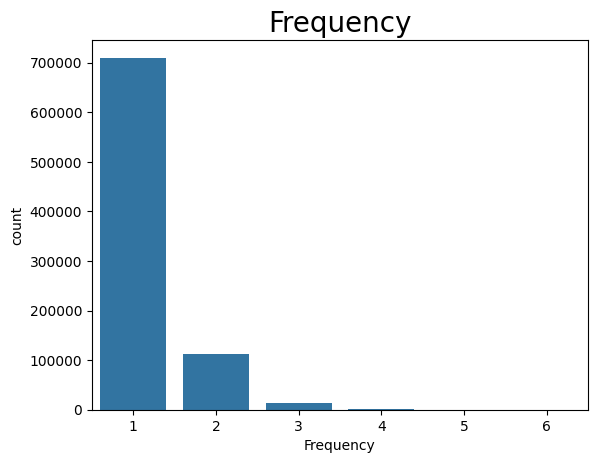

In [64]:
chart=sns.countplot(x='Frequency',data=RFM_df.toPandas(), order = RFM_df.toPandas()['Frequency'].value_counts().index)
plt.title("Frequency",fontsize='20');

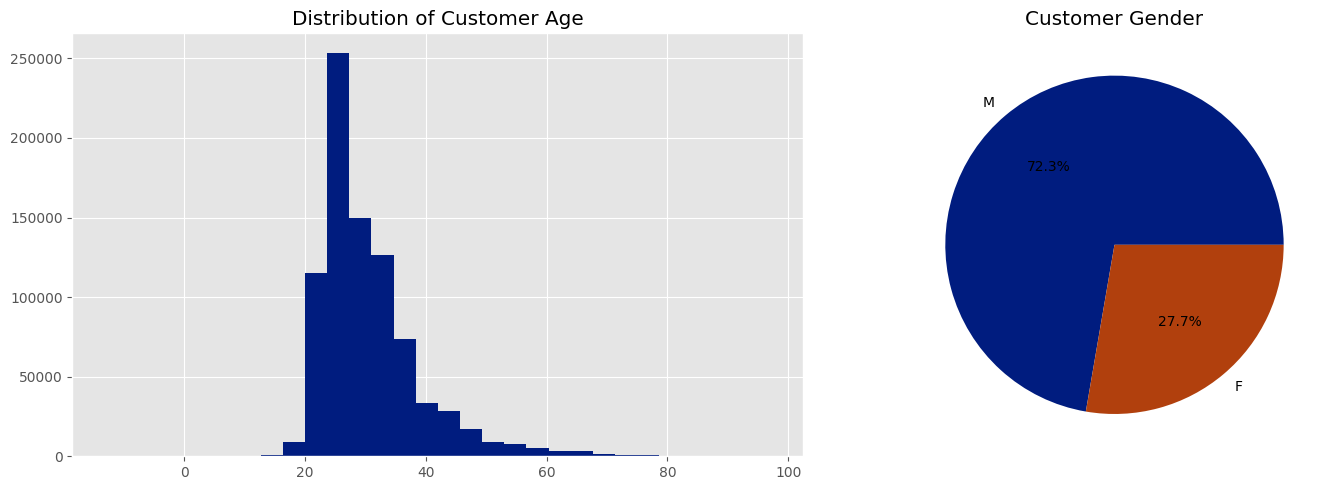

In [65]:
plt.style.use("ggplot")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
palette_color = sns.color_palette('dark')

# Plot the histogram in the first subplot
ax[0].hist(x=RFM_df.toPandas()['CustomerAge'], bins=30, color=palette_color[0])
ax[0].set_title("Distribution of Customer Age")

# Plot the pie chart in the second subplot
gender_counts = RFM_df.toPandas()['CustGender'].value_counts()
ax[1].pie(gender_counts, autopct='%1.1f%%', colors=palette_color, labels=gender_counts.index)
ax[1].set_title("Customer Gender")

plt.tight_layout()
plt.show()


<ipython-input-66-66908a9020f0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(y='CustLocation',data=RFM_df.toPandas(),palette='rocket', order = RFM_df.toPandas()['CustLocation'].value_counts()[:20].index)


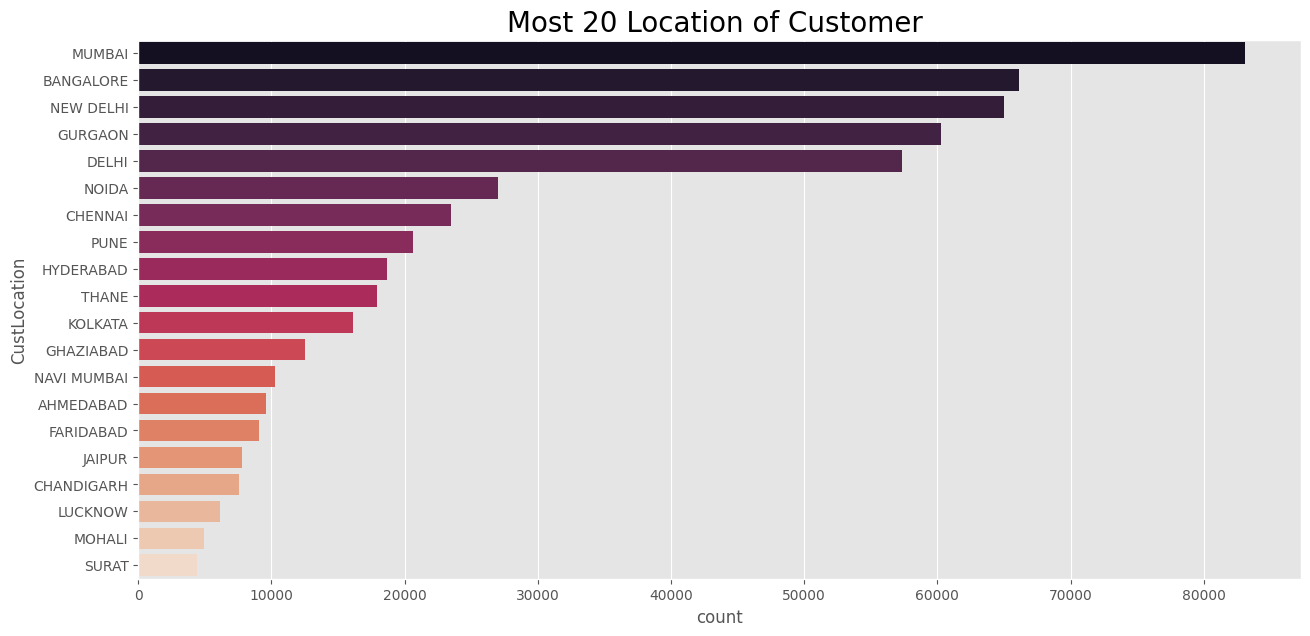

In [66]:
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=RFM_df.toPandas(),palette='rocket', order = RFM_df.toPandas()['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",fontsize='20');

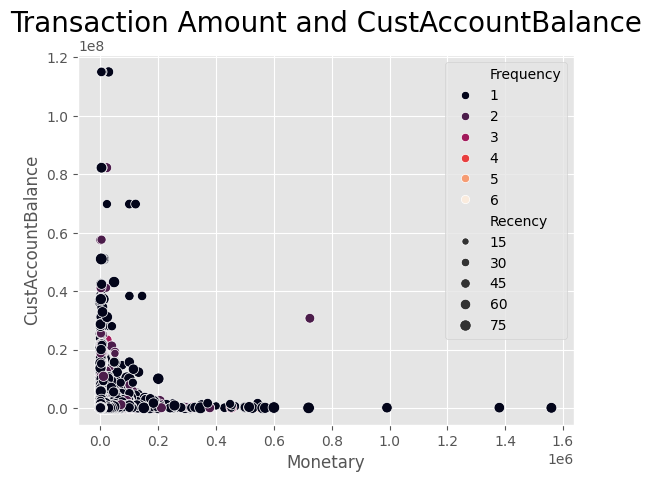

In [67]:
#plt.style.use("fivethirtyeight")
sns.scatterplot(x='Monetary',y='CustAccountBalance',data=RFM_df.toPandas(), palette='rocket',hue='Frequency',size='Recency' )
plt.title("Transaction Amount and CustAccountBalance",fontsize='20');

In [68]:
RFM_df.show(5)

+---------+----------+------------+------------------+--------+-----------+-------+---------------+
|Frequency|CustGender|CustLocation|CustAccountBalance|Monetary|CustomerAge|Recency|TransactionDate|
+---------+----------+------------+------------------+--------+-----------+-------+---------------+
|        2|         M|   NEW DELHI|         76340.635|  5106.0|         24|     26|     2016-08-09|
|        1|         M|      MUMBAI|          24204.49|  1499.0|         22|     69|     2016-08-14|
|        1|         M|     KOLKATA|          87058.65|  5000.0|         51|     65|     2016-08-18|
|        1|         F|       DELHI|         296828.37|   557.0|         28|     54|     2016-08-29|
|        2|         M|      MUMBAI|        192648.755|   750.0|         24|     56|     2016-08-01|
+---------+----------+------------+------------------+--------+-----------+-------+---------------+
only showing top 5 rows



In [69]:
RFM_df.toPandas().shape

(839081, 8)

In [77]:
# Sort DataFrame by 'TransactionDate'
RFM_df = RFM_df.orderBy('TransactionDate')

# Extract year and month from 'TransactionDate'
RFM_df = RFM_df.withColumn('TransactionDate', F.date_format(F.col('TransactionDate'), 'yyyy-MM'))

# Group by 'YearMonth' and calculate mean for numeric columns
groupby_month = RFM_df.groupBy('TransactionDate').agg(*[F.mean(col).alias(f'{col}') for col in numeric_columns])

# Display the resulting DataFrame
groupby_month.show()

+---------------+------------------+------------------+------------------+-----------------+------------------+
|TransactionDate|         Frequency|CustAccountBalance|          Monetary|      CustomerAge|           Recency|
+---------------+------------------+------------------+------------------+-----------------+------------------+
|        2016-08|1.2184870435421349|106221.89457605865| 1770.264920217549|30.26680557676783| 64.32389508287334|
|        2016-09|   1.0909442926962|105236.81917678041|1579.2537667402207|30.64630100572457| 41.68815910192947|
|        2016-10| 1.001648804616653| 95562.37132728791|1962.2925309150853|30.97938994229184|1.0041220115416323|
+---------------+------------------+------------------+------------------+-----------------+------------------+



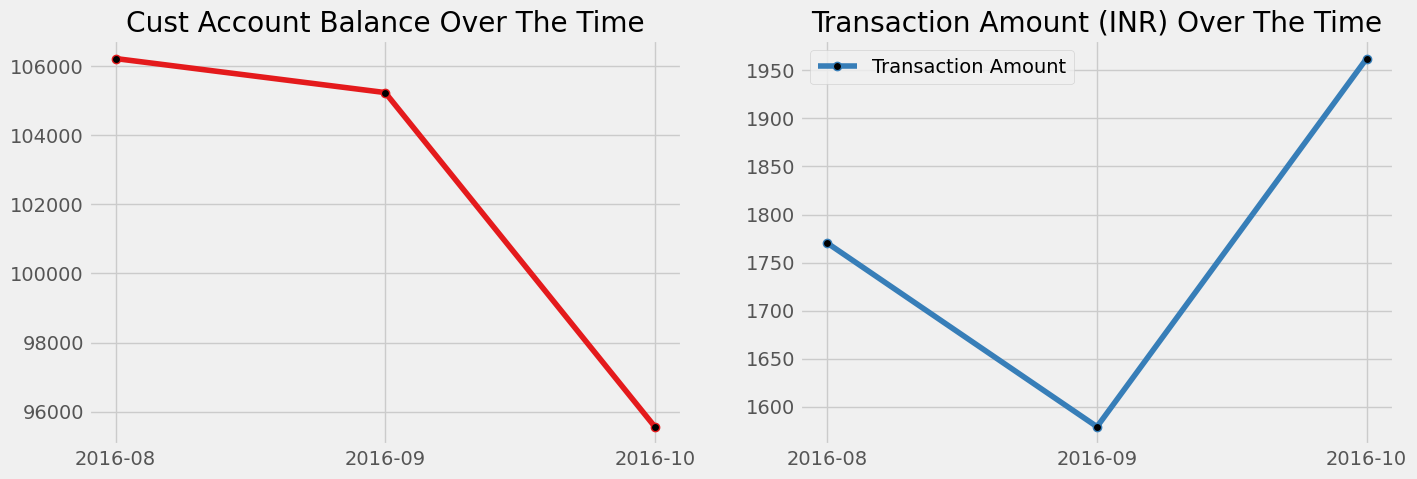

In [78]:
# Convert PySpark DataFrame to Pandas DataFrame
groupby_month = groupby_month.toPandas()

# Assume you have a color palette with different colors
custom_palette = sns.color_palette('Set1', n_colors=2)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

# Plotting the first subplot with different color for markers
ax[0].plot(groupby_month['TransactionDate'], groupby_month['CustAccountBalance'], marker='o', linestyle='-', color=custom_palette[0], label='Customer Account Balance', markerfacecolor='black', markeredgecolor=custom_palette[0])
ax[0].set_title('Cust Account Balance Over The Time')

# Plotting the second subplot with a different color for markers
ax[1].plot(groupby_month['TransactionDate'], groupby_month['Monetary'], marker='o', linestyle='-', color=custom_palette[1], label='Transaction Amount', markerfacecolor='black', markeredgecolor=custom_palette[1])
ax[1].set_title("Transaction Amount (INR) Over The Time")

plt.legend()
plt.show()

Observations from the above graph 💡:

- The average Customer Account Balance significantly decreases for the last three months of the year.
- The average Transaction Amount decreases then increases over the time for the second half of the year.



<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">5. Feature Engineering </h2><a id = "5"></a>

In [79]:
RFM_df = RFM_df.toPandas()

In [ ]:
RFM_df=RFM_df.reset_index(drop=True)

In [80]:
RFM_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetary,CustomerAge,Recency,TransactionDate,YearMonth
0,2,M,NEW DELHI,76340.635,5106.0,24,26,2016-08,2016-08
1,1,M,MUMBAI,24204.490,1499.0,22,69,2016-08,2016-08
2,1,M,KOLKATA,87058.650,5000.0,51,65,2016-08,2016-08
3,1,F,DELHI,296828.370,557.0,28,54,2016-08,2016-08
4,2,M,MUMBAI,192648.755,750.0,24,56,2016-08,2016-08


In [ ]:
RFM_df.drop(columns=['CustLocation','TransactionDate','YearMonth'],inplace=True)

In [ ]:
RFM_df['CustGender']=RFM_df['CustGender'].map({'M':1,'F':0})

In [ ]:
RFM_df.drop(RFM_df[RFM_df['Recency']<=0].index,inplace=True)

In [ ]:
RFM_df

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
0,1,0,703891.99,2000.00,29.0,337
1,1,1,156310.08,1347.90,-51.0,337
2,1,1,95792.79,9900.00,216.0,337
3,1,1,1753.41,154.05,27.0,337
4,1,1,39579.53,194.00,30.0,337
...,...,...,...,...,...,...
879352,1,1,1307.91,1058.91,25.0,1
879353,1,0,12320.47,309.63,18.0,1
879354,1,1,1304.80,50.00,24.0,1
879355,1,0,17989.61,250.00,-57.0,1


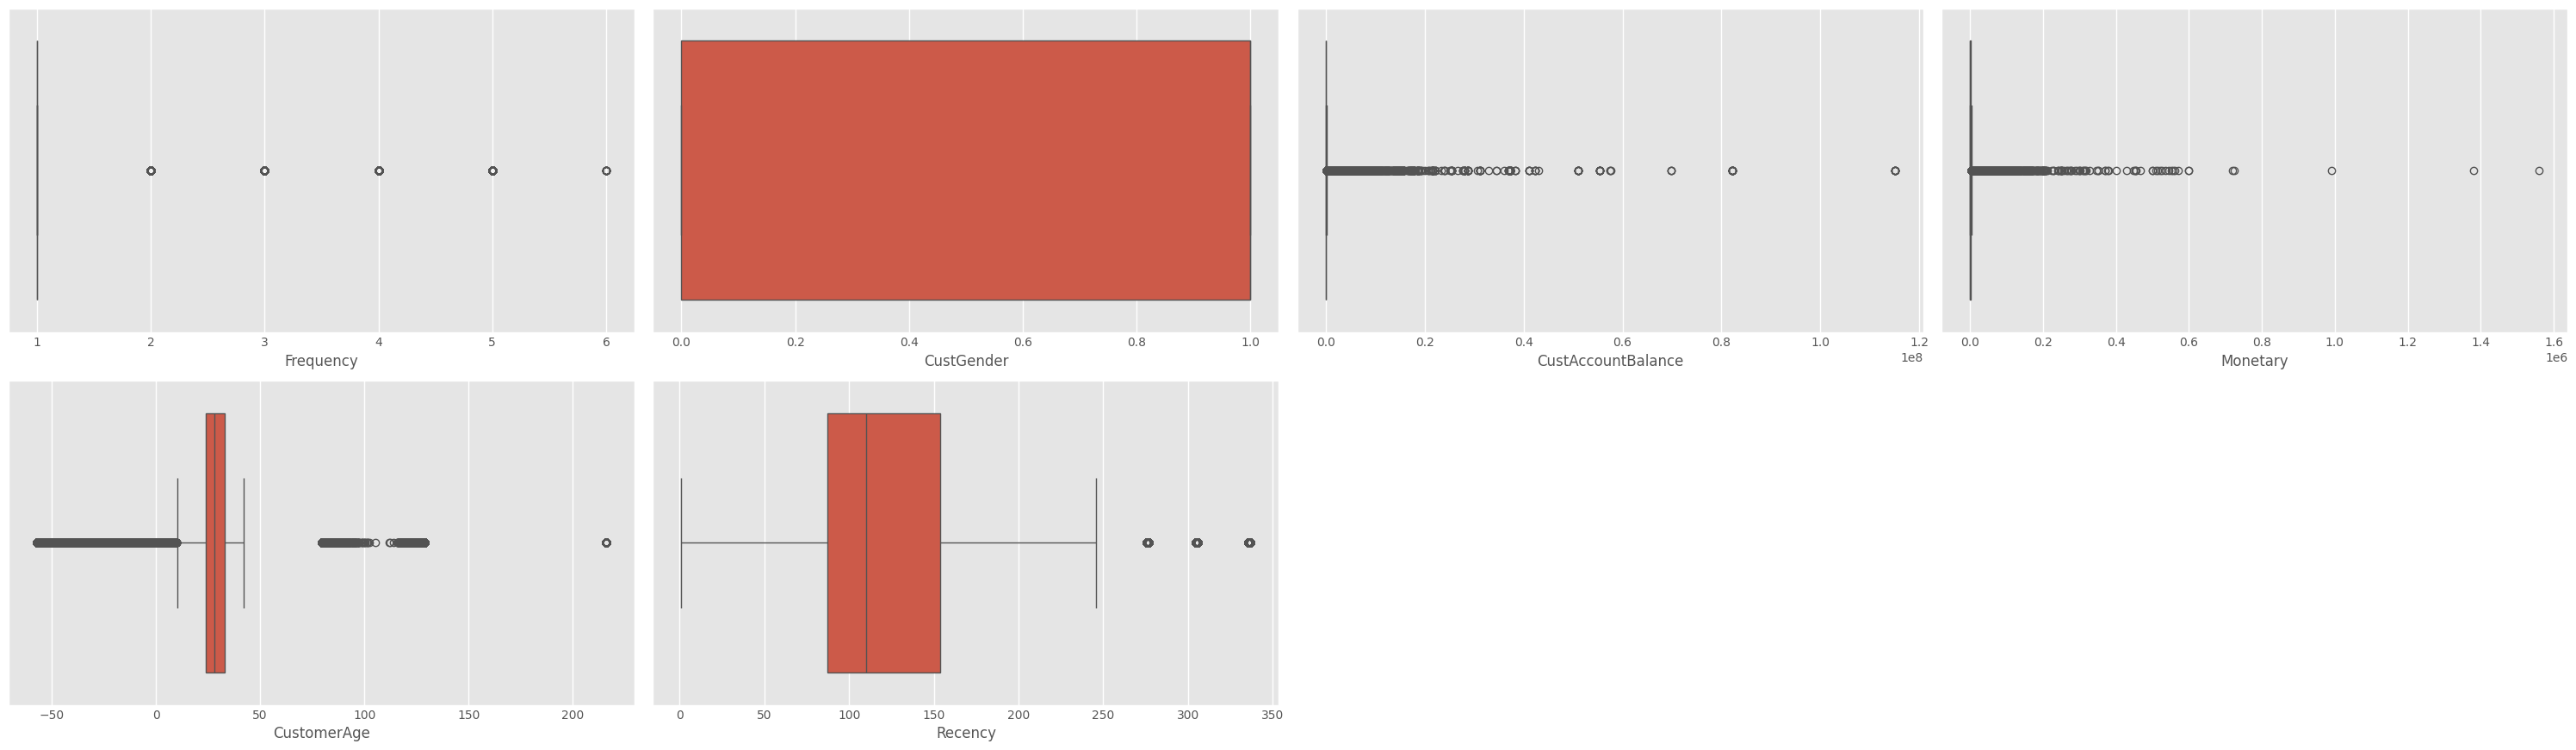

In [ ]:
# checking for outliers
plt.style.use("ggplot")
plt.figure(figsize=(30,30))
for index,column in enumerate(RFM_df.columns):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=RFM_df,x=column)

plt.tight_layout(pad = 1.0)

In [ ]:
# Function to calculate outliers information
def get_outliers_info(column):
    q1 = RFM_df[column].quantile(0.25)
    q3 = RFM_df[column].quantile(0.75)
    iqr = q3 - q1
    lower_range = q1 - 1.5 * iqr
    upper_range = q3 + 1.5 * iqr

    outliers = RFM_df[(RFM_df[column] < lower_range) | (RFM_df[column] > upper_range)]
    num_outliers = len(outliers)
    percent_outliers = (num_outliers / len(RFM_df)) * 100

    return pd.Series({
        'lower_range': lower_range,
        'upper_range': upper_range,
        'num_outliers': num_outliers,
        'percent_outliers': percent_outliers
    })

# Create outliers_df
outliers_df = pd.DataFrame()
outliers_df['cols'] = RFM_df.columns
outliers_df = pd.concat([outliers_df, outliers_df['cols'].apply(get_outliers_info)], axis=1)

# Set index to 'cols' and display as a table
outliers_df.set_index('cols', inplace=True)
outliers_df.style.format({'lower_range': '{:.2f}', 'upper_range': '{:.2f}', 'num_outliers': '{:.0f}', 'percent_of_outliers': '{:.2f}%'})
#print(outliers_df)

,lower_range,upper_range,num_outliers,percent_outliers
cols,,,,
Frequency,1.00,1.00,141961,16.143728
CustGender,-1.50,2.50,0,0.000000
CustAccountBalance,-78334.78,145468.02,116569,13.256163
Monetary,-1750.00,3450.00,91112,10.361207
CustomerAge,10.50,46.50,139949,15.914924
Recency,-13.50,254.50,96016,10.918887


Observations 💡:
While certain variables may appear to be outliers, ultimately I chose not to exclude any data. One detail worth noting is that the reported age may have negative values. This is due to the fact that it is possible for a Life Saver youth savings account to be opened in the name of a grandchild or child.

In [ ]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, Frequency to Recency
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lower_range       6 non-null      float64
 1   upper_range       6 non-null      float64
 2   num_outliers      6 non-null      float64
 3   percent_outliers  6 non-null      float64
dtypes: float64(4)
memory usage: 412.0+ bytes


In [ ]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns, threshold=1.5):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Columns for which you want to remove outliers

# Remove outliers using IQR method
RFM_no_outliers = remove_outliers_iqr(RFM_df, RFM_df.columns)

print("Original DataFrame:")
print(RFM_df)
print("\nDataFrame without outliers:")
print(RFM_no_outliers)


Original DataFrame:
        Frequency  CustGender  CustAccountBalance  Monetary  CustomerAge  \
0               1           0           703891.99   2000.00         29.0   
1               1           1           156310.08   1347.90        -51.0   
2               1           1            95792.79   9900.00        216.0   
3               1           1             1753.41    154.05         27.0   
4               1           1            39579.53    194.00         30.0   
...           ...         ...                 ...       ...          ...   
879352          1           1             1307.91   1058.91         25.0   
879353          1           0            12320.47    309.63         18.0   
879354          1           1             1304.80     50.00         24.0   
879355          1           0            17989.61    250.00        -57.0   
879356          1           1             3829.82   2290.00         30.0   

        Recency  
0           337  
1           337  
2           3

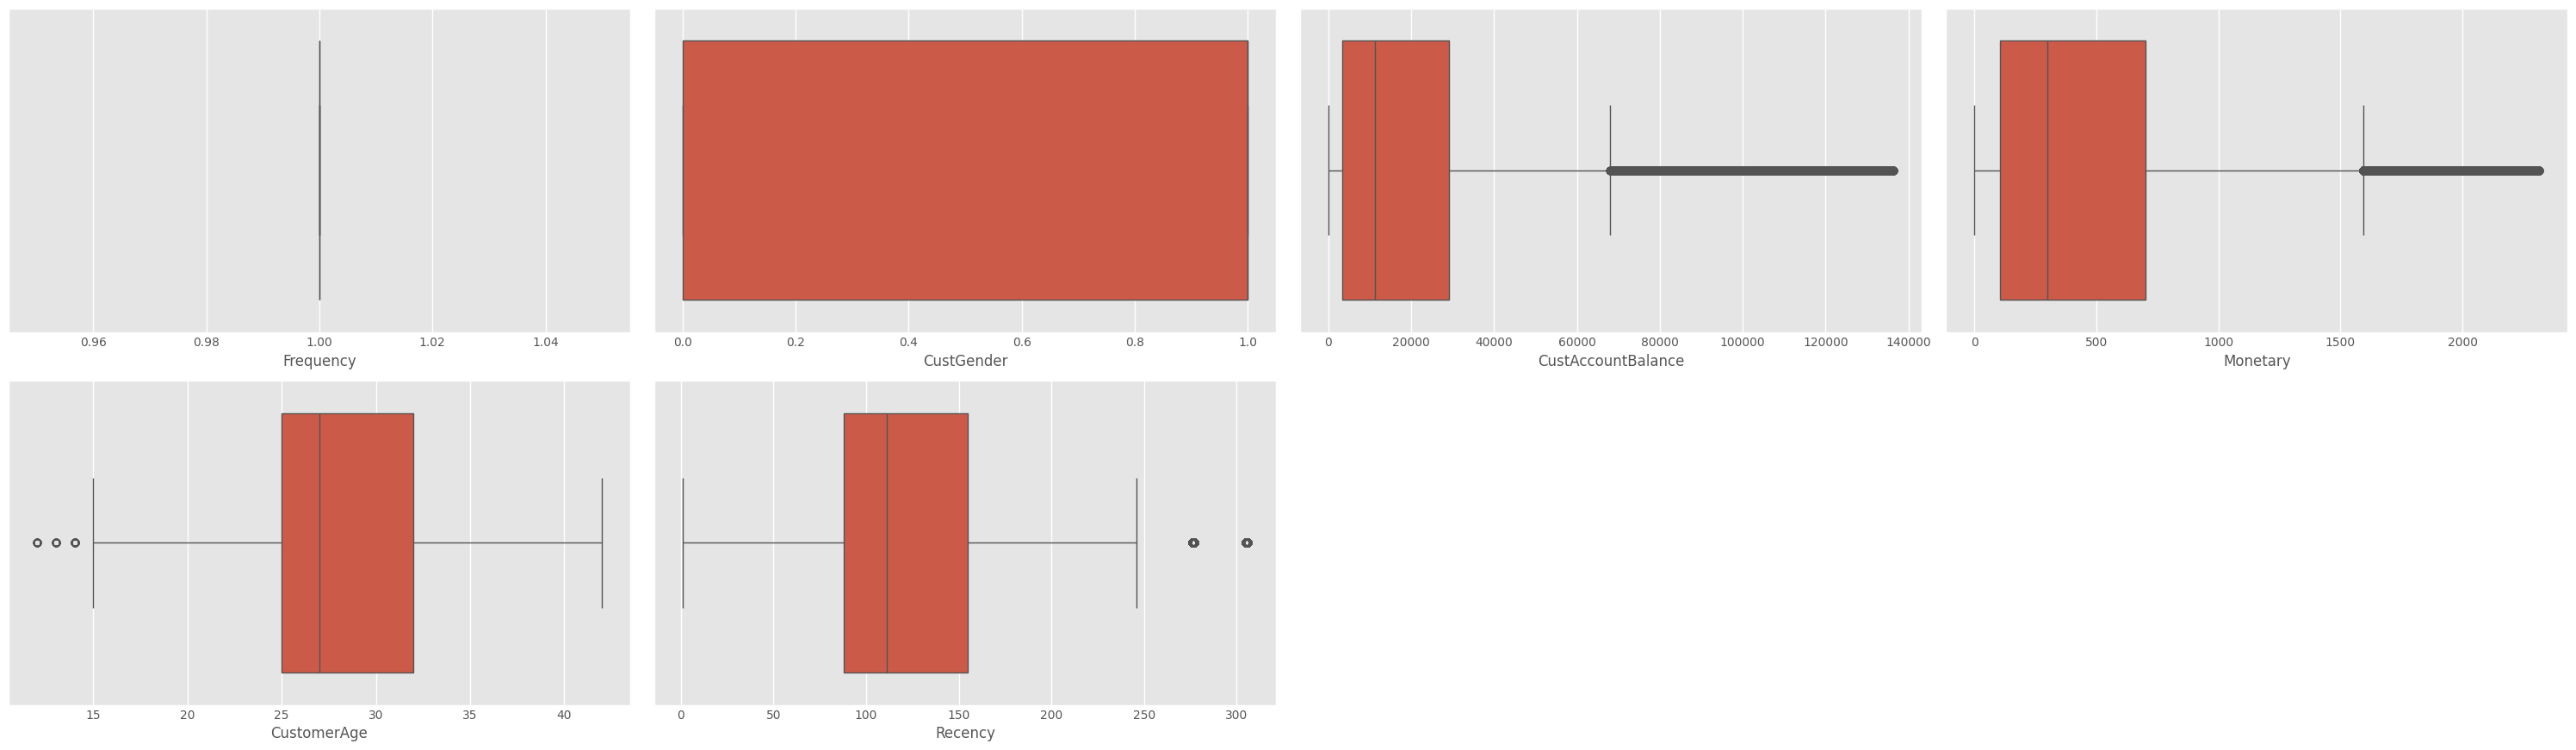

In [ ]:
# checking for outliers
plt.style.use("ggplot")
plt.figure(figsize=(30,30))
for index,column in enumerate(RFM_no_outliers.columns):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=RFM_no_outliers,x=column)

plt.tight_layout(pad = 1.0)

In [ ]:
# data scaling
scaler = StandardScaler()
RFM_scaL=scaler.fit_transform(RFM_no_outliers)
RFM_scal=pd.DataFrame(RFM_scaL,columns=RFM_no_outliers.columns)
RFM_scal.head()

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
0,0.0,-1.659201,0.751183,-0.947592,0.314562,2.414185
1,0.0,0.602700,0.277794,-0.911195,-1.039504,2.414185
2,0.0,0.602700,-0.789542,-0.909280,0.121124,2.414185
3,0.0,0.602700,0.432874,-0.857559,0.121124,2.414185
4,0.0,0.602700,-0.609992,-0.478269,-0.652628,2.414185


<p>the data is very very big so I will use only first 10000 rows. I am using first 10000 rows instead of random sampling for better explainability. </p>

In [ ]:
#RFM_scaled=RFM_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
#RFM_scaled.head()

In [ ]:
RFM_scaled = RFM_scal.head(10000)

### 6. Modelling

<h3 style="color:darkmagenta; font-family:Cursive">K-mean</h3>

The k-means clustering is a method of vector quantization, originally from signal processing.

The Elbow method is a graphical representation of finding the optimal 'K' in a K-means clustering algorithm.

The Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. 1: Means clusters are well apart from each other and clearly distinguished. -1: Means clusters are not well apart from each other.

The Dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering algorithms.



<img src="https://miro.medium.com/max/1200/1*rw8IUza1dbffBhiA4i0GNQ.png" alt="k-mean" >

In [ ]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(RFM_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(RFM_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)


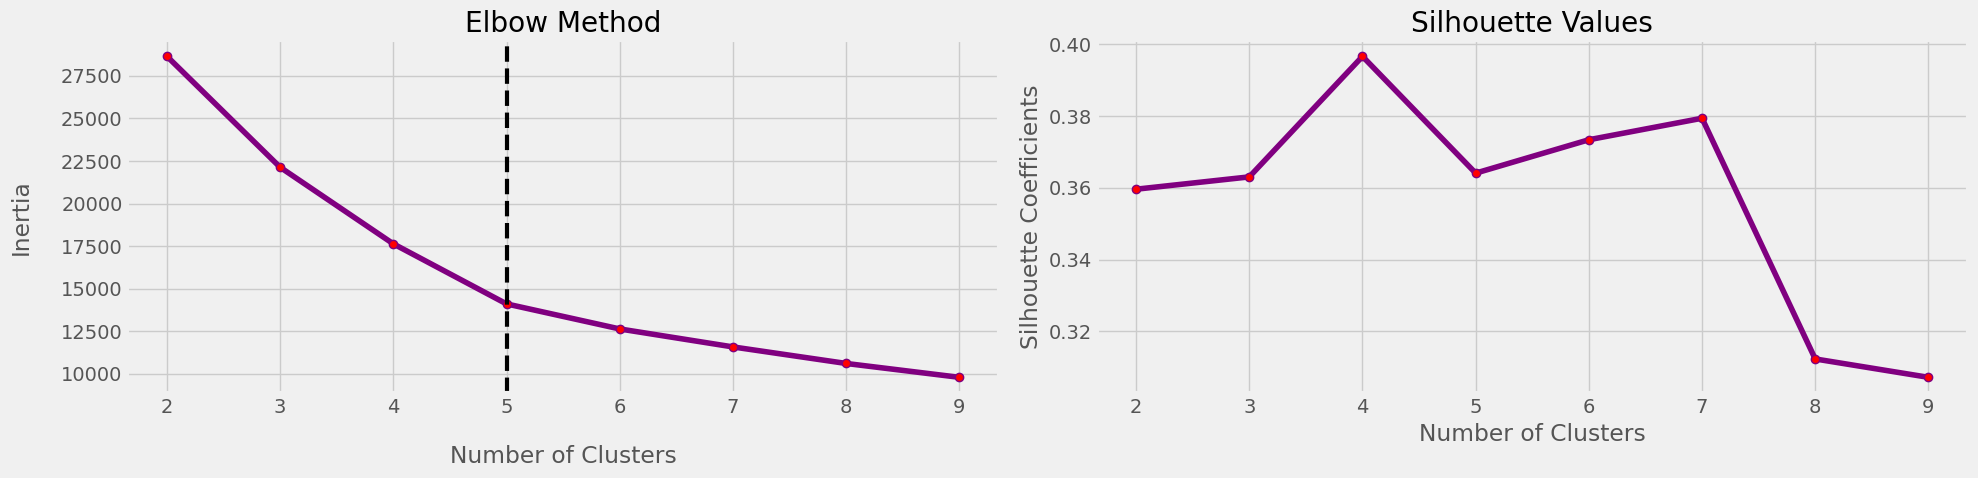

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

kl = KneeLocator(range(2, 10), inertias, curve='convex', direction="decreasing")

# Plot for Elbow Method
ax[0].plot(range(2, 10), inertias, color='purple', marker='o', linestyle='-', label='Elbow Method',markerfacecolor='red')
ax[0].set_xticks(range(2, 10))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

# Plot for Silhouette Coefficients
ax[1].plot(range(2, 10), silhouette_coefficients, color='purple', marker='o', linestyle='-', label='Silhouette Coefficients', markerfacecolor='red')
ax[1].set_xticks(range(2, 10))
ax[1].set_title("Silhouette Values")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Coefficients")

plt.tight_layout()
plt.show()


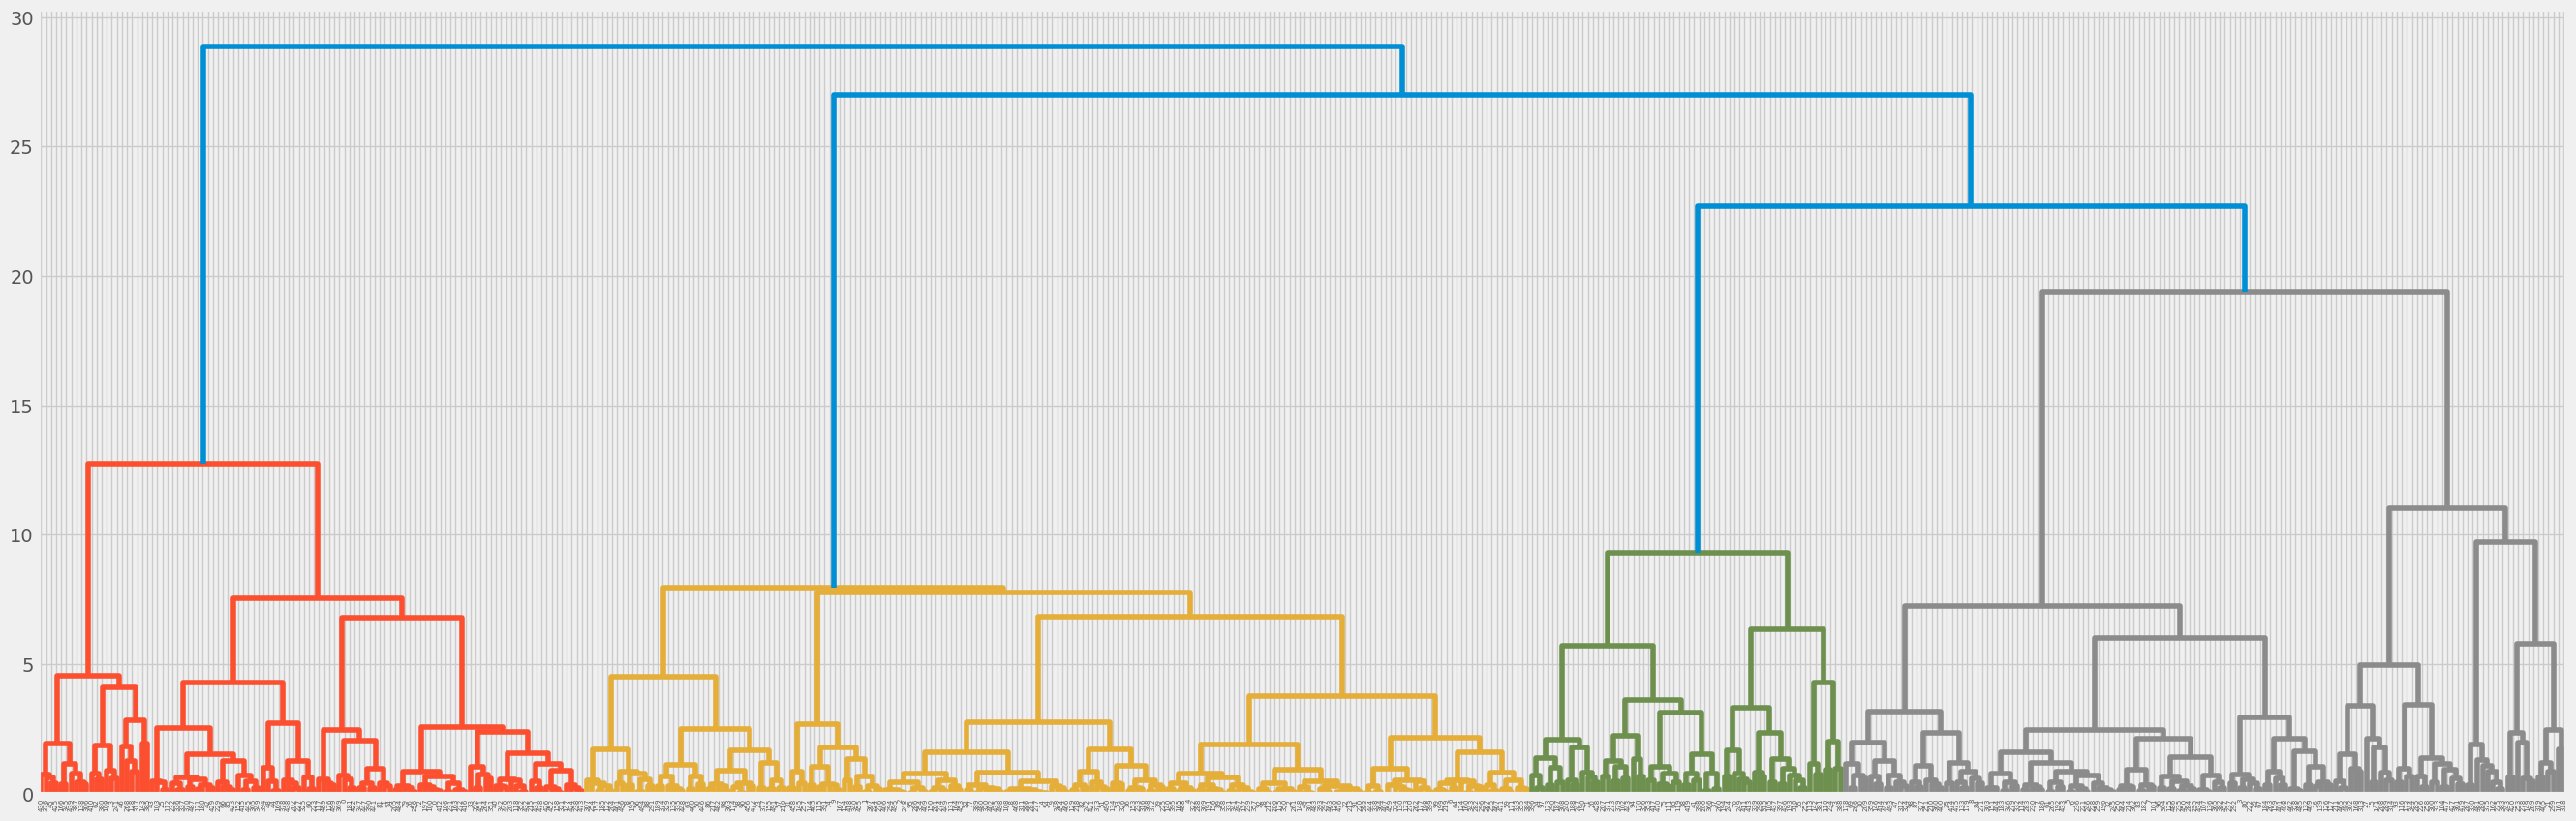

In [ ]:
plt.figure(figsize=(30,10))
z = sch.linkage(RFM_scaled.iloc[:500,:], 'ward')
sch.dendrogram(z);

<p>The three charts ensure that the number of clustering is either 4 or 5 so I will use 5 for this project.</p>

In [ ]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)
kmeans.fit(RFM_scaled)
RFM_scaled['Cluster']=kmeans.labels_
RFM_scaled.head()

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\1586373048.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,Cluster
0,0.0,-1.659201,0.751183,-0.947592,0.314562,2.414185,3
1,0.0,0.602700,0.277794,-0.911195,-1.039504,2.414185,0
2,0.0,0.602700,-0.789542,-0.909280,0.121124,2.414185,0
3,0.0,0.602700,0.432874,-0.857559,0.121124,2.414185,0
4,0.0,0.602700,-0.609992,-0.478269,-0.652628,2.414185,0


In [ ]:
# Creating a target column "Cluster" for storing the cluster segment
df_segm = pd.concat([RFM_no_outliers.head(10000).reset_index(drop=True),pd.DataFrame({'Cluster':kmeans.labels_})],axis=1)
df_segm

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,Cluster
0,1,0,42829.91,5.0,30.0,306,3
1,1,1,29711.74,24.0,23.0,306,0
2,1,1,134.61,25.0,29.0,306,0
3,1,1,34009.18,52.0,29.0,306,0
4,1,1,5110.16,250.0,25.0,306,0
...,...,...,...,...,...,...,...
9995,1,1,16525.63,160.0,23.0,306,0
9996,1,1,19014.11,799.0,26.0,306,0
9997,1,1,57133.46,400.0,33.0,306,2
9998,1,1,4241.44,199.0,27.0,306,0


In [ ]:
df_segm_analysis = df_segm.groupby(['Cluster']).mean().round(4)
df_segm_analysis

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
Cluster,,,,,,
0,1.0,1.0000,10668.8306,258.7114,25.4178,306.0
1,1.0,0.9878,15075.1092,397.4467,34.4571,306.0
2,1.0,0.7308,90023.5255,567.2340,30.7862,306.0
3,1.0,0.0000,16604.3656,375.8928,26.8234,306.0
4,1.0,0.7513,20122.8377,1600.9073,29.8640,306.0


C:\Users\linco\AppData\Local\Temp\ipykernel_3024\3126987351.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




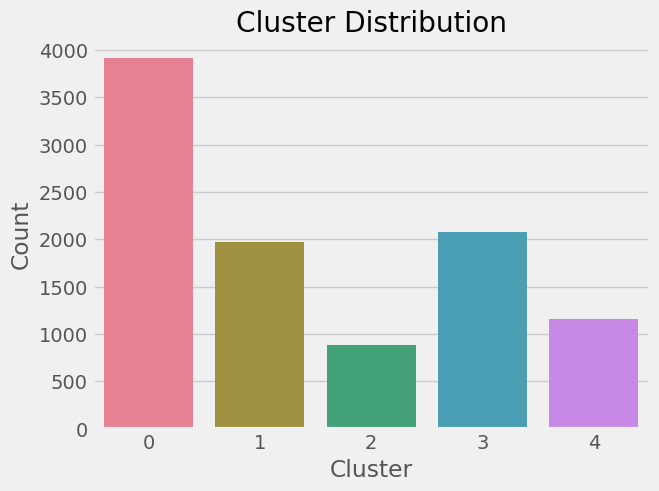

In [ ]:
custom_palette = sns.color_palette("husl", n_colors=len(RFM_scaled['Cluster'].unique()))
sns.countplot(x='Cluster', data=RFM_scaled, palette=custom_palette)

plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [ ]:
#sns.pairplot(df_scaled,hue='Label');

In [ ]:
# Assuming 'Cluster' is a column in RFM_scaled DataFrame
RFM_scaled['Cluster'] = RFM_scaled['Cluster'].astype(int)

attributes = RFM_scaled.columns[:6]
colors = ['yellow', 'red', 'blue', 'magenta', 'orange']
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

fig = go.Figure()

for index in range(5):
    cluster_data = RFM_scaled.loc[RFM_scaled['Cluster'] == index, attributes]
    mean_values = np.mean(cluster_data, axis=0)

    fig.add_trace(go.Scatterpolar(
        r=mean_values.values,  # Ensure 'r' is a NumPy array
        theta=attributes,
        fill='toself',
        name=cluster[index],
        line=dict(color=colors[index]),
        #opacity=0.3,
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title="Radar plot - Cluster attributes (Normalized Values)"
)

fig.show()


C:\Users\linco\AppData\Local\Temp\ipykernel_3024\1138846336.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



*   All clusters has customers with highest Recency.
*   cluster4 has customers with highest Monetary.
*   cluster2 has customers with highest Customer Account Balance.




<p></p>

### PCA

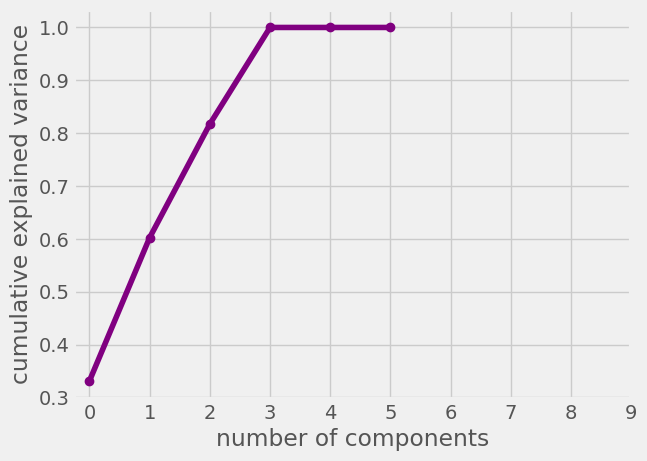

In [ ]:
# here we want to check how many component we need to explain 70-80%  of the variance
plt.style.use("fivethirtyeight")
RFM = RFM_scaled.iloc[:,:-1]
pca = PCA().fit(RFM)
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')  #EX: cusum([4,2,3,1,6]) ==>[4,6,9,10,16]
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# x tickes
plt.xticks(np.arange(0, 10, 1))
plt.show();

In [ ]:
# I will take 2 components as it explains 80% of variance
pca = PCA(n_components=2)
pca_data = pca.fit(RFM)

df_pca_components = pd.DataFrame(
    data=pca_data.components_.round(4),
    columns=RFM.columns.values,
    index=['PCA 1', 'PCA 2'])

df_pca_components

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
PCA 1,0.0,-0.0568,0.5401,0.5988,0.5886,-0.0
PCA 2,-0.0,-0.9060,0.1974,0.0926,-0.3627,-0.0


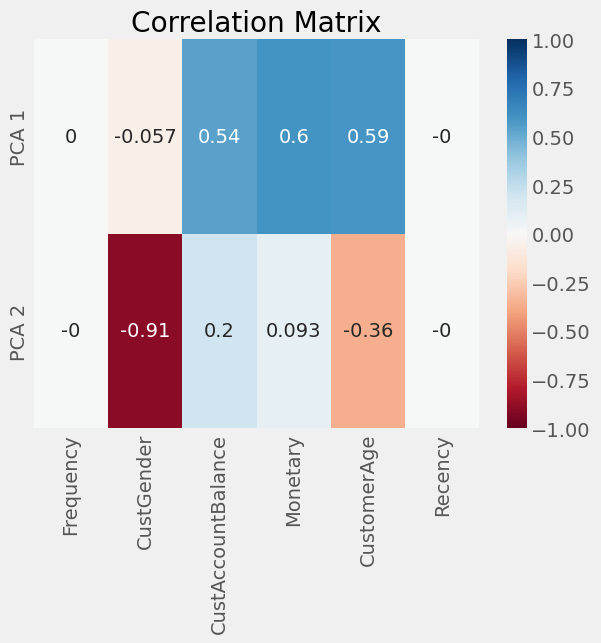

In [ ]:
s = sns.heatmap(
    df_pca_components,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    annot=True
)
plt.title('Correlation Matrix')
plt.show()

PCA 1 has a positive correlation with Customer Account Balance, Monetary, and Age. These features are related to how much money a customer have in the bank.

On the other hand, PCA 2 has a negative correlation with Age, Customer Gender. These features are related to sex and lifestyle of a customer.

### Implementing K-Means Clustering with PCA

In [ ]:
inertia = []
silhouette = []
pca_data = pca_data.transform(RFM)

for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

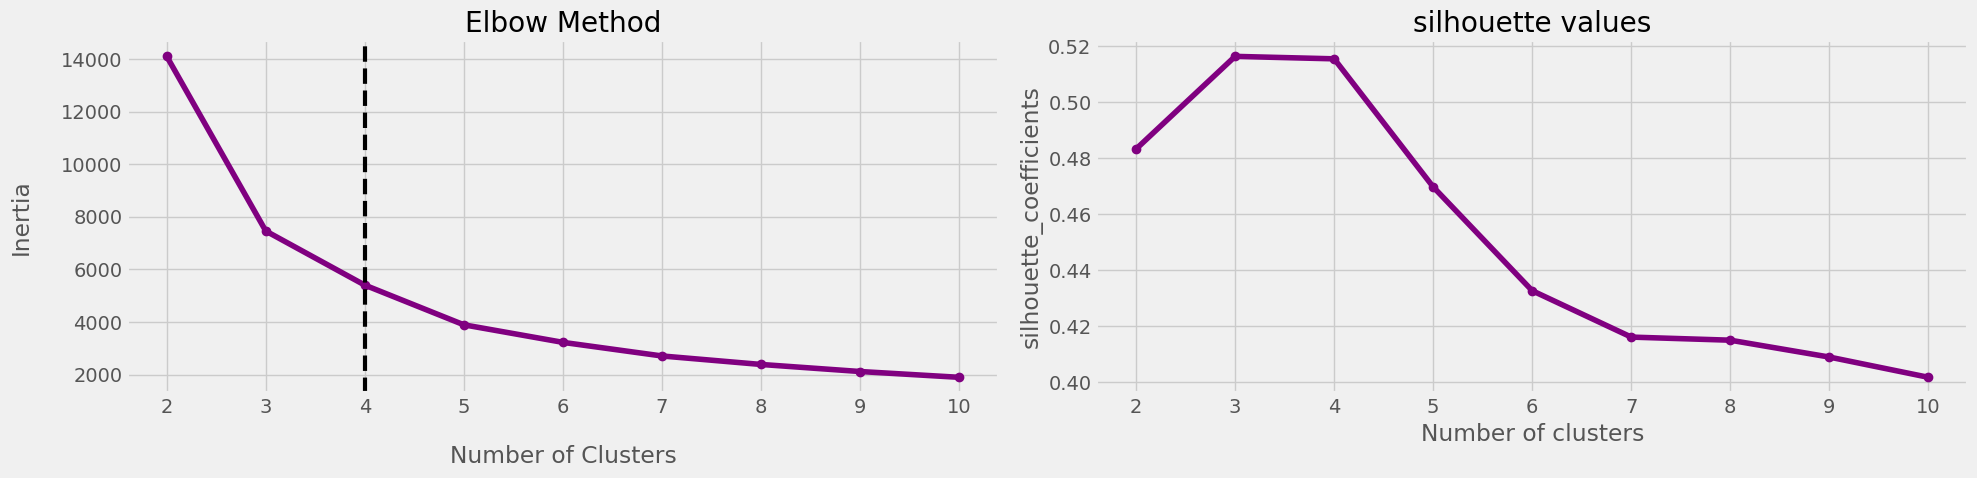

In [ ]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
Pkl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")
# draw Elbow
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=Pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)
# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

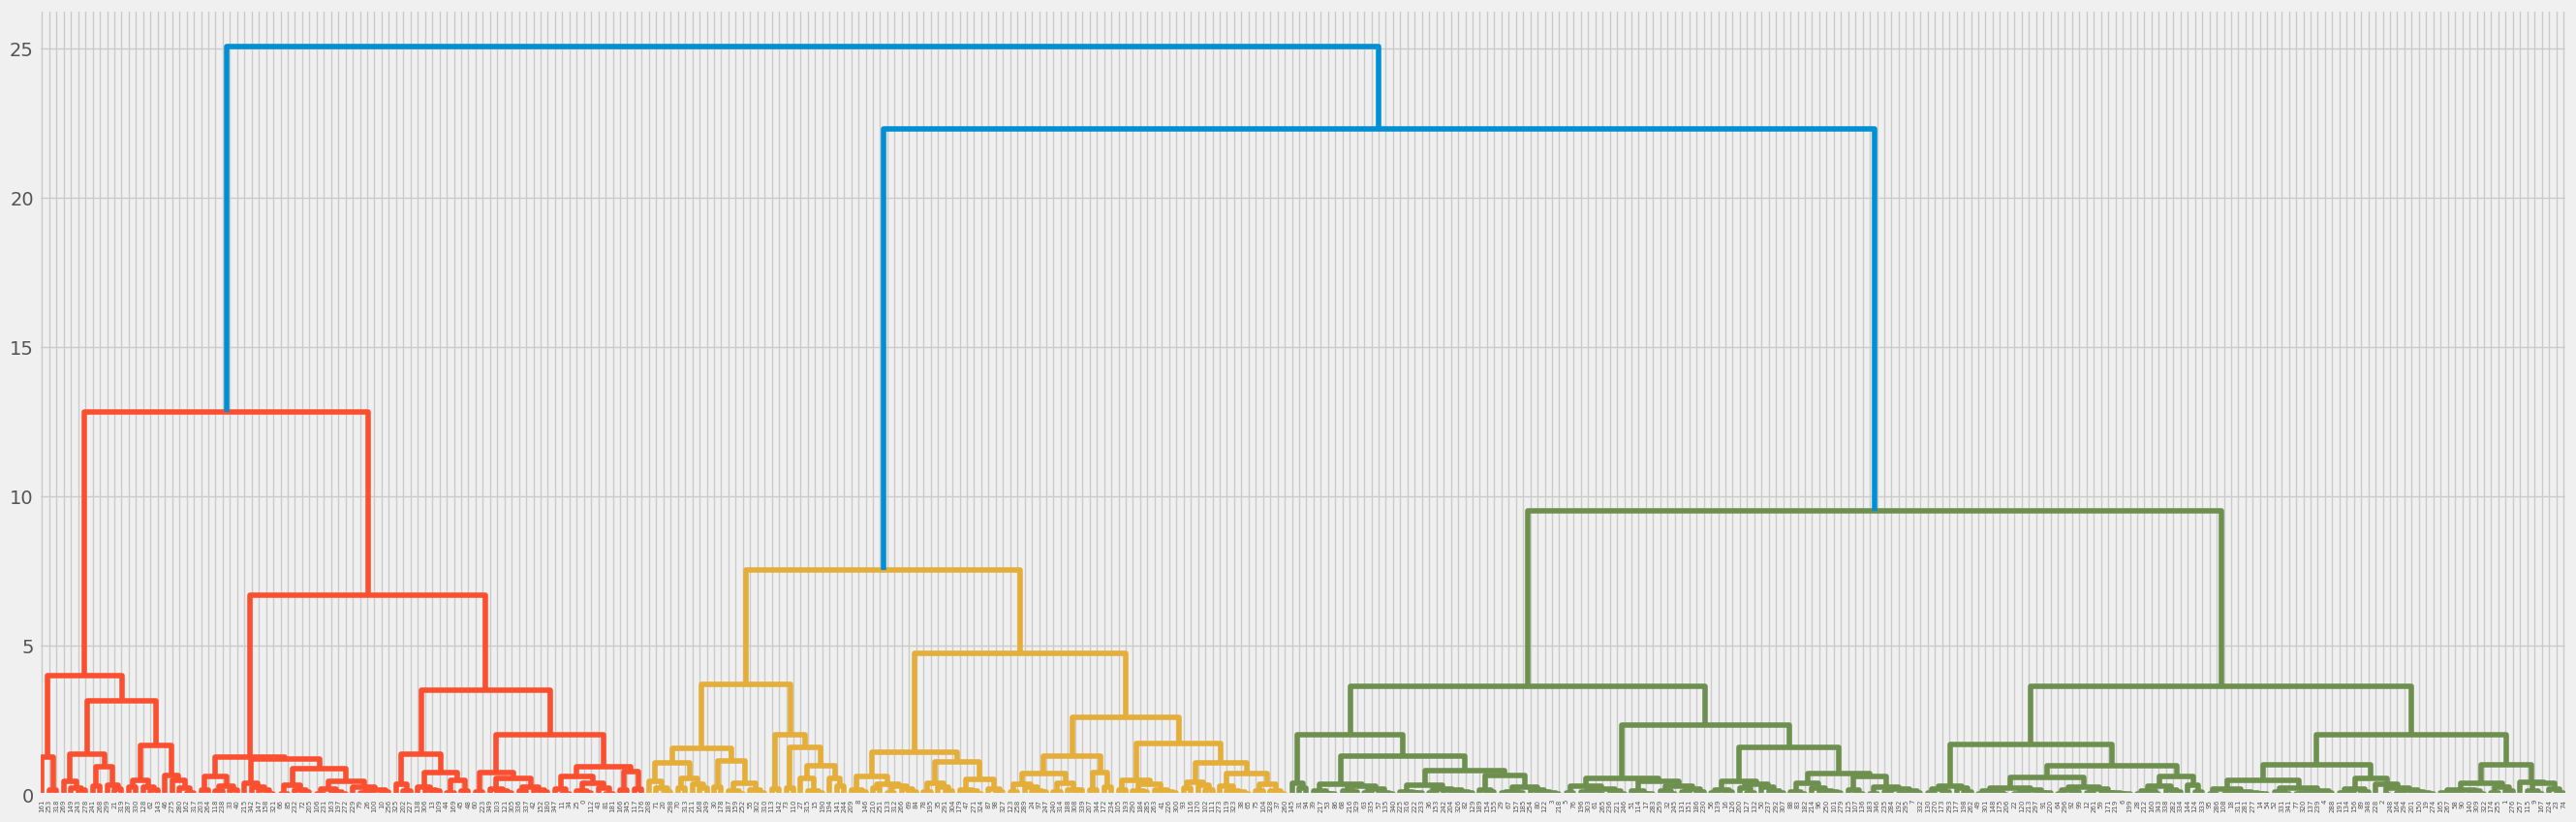

In [ ]:
plt.figure(figsize=(30,10))
z = sch.linkage(pca_data[:350,:], 'ward')
sch.dendrogram(z);

<p>the three charts insure that the number of clustering is 4 so I will use it</p>

In [ ]:
PCA_kmeans = KMeans(n_clusters=4 , **kmeans_set)
PCA_kmeans.fit(pca_data)
# create a dataframe for the pca data
rfm = RFM_no_outliers.head(10000)
df_segm_pca = pd.concat([rfm.reset_index(drop=True), pd.DataFrame(pca_data)], axis=1)
df_segm_pca.columns.values[-2:] = ['PCA 1', 'PCA 2']
df_segm_pca['Cluster'] = PCA_kmeans.labels_

df_segm_pca

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,PCA 1,PCA 2,Cluster
0,1,0,42829.91,5.0,30.0,306,0.136436,1.474199,3
1,1,1,29711.74,24.0,23.0,306,-1.022903,-0.174088,0
2,1,1,134.61,25.0,29.0,306,-0.915045,-0.805610,0
3,1,1,34009.18,52.0,29.0,306,-0.223840,-0.559487,0
4,1,1,5110.16,250.0,25.0,306,-1.015432,-0.449600,0
...,...,...,...,...,...,...,...,...,...
9995,1,1,16525.63,160.0,23.0,306,-1.123904,-0.243909,0
9996,1,1,19014.11,799.0,26.0,306,-0.000825,-0.323331,0
9997,1,1,57133.46,400.0,33.0,306,1.081506,-0.613670,1
9998,1,1,4241.44,199.0,27.0,306,-0.863137,-0.605162,0


In [ ]:
df_segm_pca_analysis = df_segm_pca.groupby(['Cluster']).mean().round(4)
df_segm_pca_analysis

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,PCA 1,PCA 2
Cluster,,,,,,,,
0,1.0,1.0000,10457.7578,266.0509,26.5978,306.0,-0.7109,-0.5208
1,1.0,0.9984,36212.9880,875.3443,33.1011,306.0,1.2307,-0.6822
2,1.0,0.0378,48325.5614,1005.0438,30.9689,306.0,1.4961,1.5452
3,1.0,0.0011,13978.0007,316.0242,25.8801,306.0,-0.5384,1.6106


From above result, we can say that:

* Cluster 0: Low value customers as they have lowest Balance and Monetary value.
* Cluster 2: High value customers as they have highest Balance and Monetary value.

In [ ]:
#sns.pairplot(pca_df,hue='label');

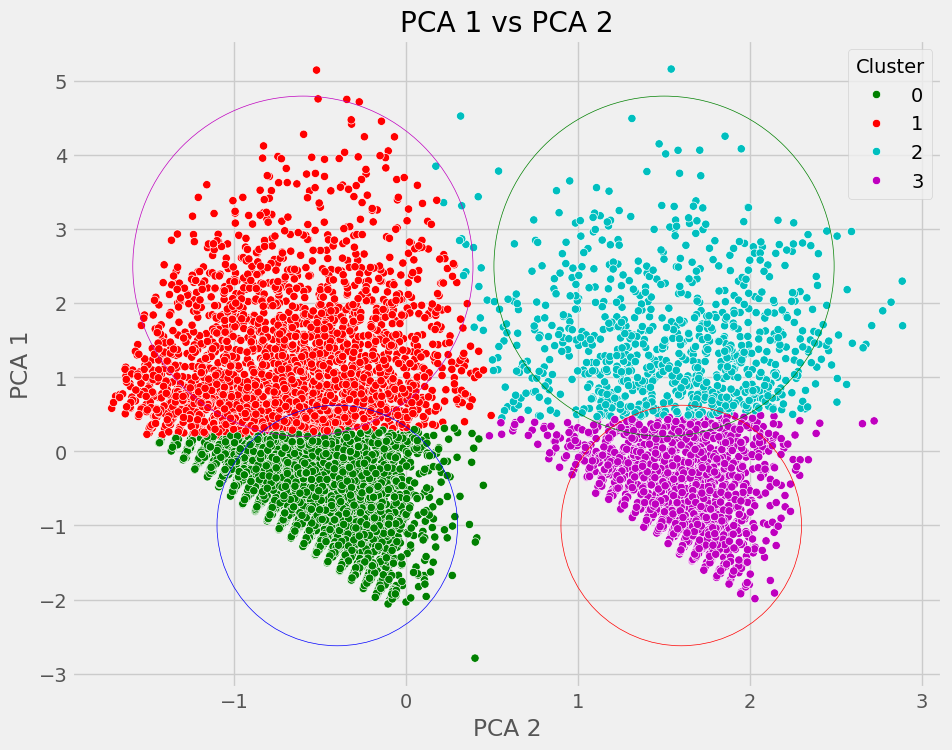

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_segm_pca['PCA 2'],
    y=df_segm_pca['PCA 1'],
    hue=df_segm_pca['Cluster'],
    palette=['g','r','c','m']
)
plt.scatter(1.5, 2.5 , s=60000, facecolors='none', edgecolors='g' )
plt.scatter(-0.6, 2.5 , s=60000, facecolors='none', edgecolors='m' )
plt.scatter(-0.4, -1 , s=30000, facecolors='none', edgecolors='b' )
plt.scatter(1.6, -1 , s=30000, facecolors='none', edgecolors='r' )

plt.title('PCA 1 vs PCA 2')
plt.show()

In [ ]:
pca_df = df_segm_pca[['PCA 1', 'PCA 2', 'Cluster']]

pca_df['Cluster'] = pca_df['Cluster'].astype(int)

attributes = pca_df.columns[:2]
colors = ['yellow', 'red', 'blue', 'magenta']
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

fig = go.Figure()

for index in range(4):
    cluster_data = pca_df.loc[pca_df['Cluster'] == index, attributes]
    mean_values = np.mean(cluster_data, axis=0)

    fig.add_trace(go.Scatterpolar(
        r=mean_values.values,  # Ensure 'r' is a NumPy array
        theta=attributes,
        fill='toself',
        name=cluster[index],
        line=dict(color=colors[index]),
        #opacity=0.3,
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title="Radar plot - Cluster attributes (Normalized Values)"
)

fig.show()

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\1220637132.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



I will go ahead without PCA. and Then I will save the k means model with n_cluster = 5 and data for classification problem.

### Saving the kmeans clustering model and the data with cluster label

In [ ]:
#Saving Scikitlearn models
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")

['kmeans_model.pkl']

In [ ]:
df_segm.to_csv("Clustered_Customer_Data.csv")

### 7. Classification using decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics

In [ ]:
#Split Dataset
x = df_segm.drop(['Cluster'],axis=1)
y= df_segm[['Cluster']]
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.1, stratify=y,random_state=42)

### 8. Modelling for Classification

In [ ]:
model= DecisionTreeClassifier(criterion="entropy")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
#Confusion_Matrix
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[390   1   0   0   0]
 [  1 195   1   0   0]
 [  0   2  86   1   0]
 [  0   0   0 206   2]
 [  1   0   4   0 110]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       391
           1       0.98      0.99      0.99       197
           2       0.95      0.97      0.96        89
           3       1.00      0.99      0.99       208
           4       0.98      0.96      0.97       115

    accuracy                           0.99      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [ ]:
import pickle
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

<p></p>